# 03b. Entrenar YOLOv8 Detector (Transfer Learning)

In [1]:
from ultralytics import YOLO
import os

## Configuration

In [2]:

DATA_YAML = '../data/yolo_dataset/data.yaml'
MODEL_SAVE_DIR = '../models'

EPOCHS = 20
IMG_SIZE = 640
BATCH_SIZE = 16
MODEL_SIZE = 'yolov8n'

print(f'Model: {MODEL_SIZE}')
print(f'Epochs: {EPOCHS}')
print(f'Image Size: {IMG_SIZE}')
print(f'Batch Size: {BATCH_SIZE}')

Model: yolov8n
Epochs: 20
Image Size: 640
Batch Size: 16


## Cargamos el dataset

In [3]:

model = YOLO(f'{MODEL_SIZE}.pt')

print(f'Loaded pre-trained {MODEL_SIZE} model')
print(f'  This model was trained on COCO dataset (80 classes)')
print(f'  We will fine-tune it for license plate detection (1 class)')

Loaded pre-trained yolov8n model
  This model was trained on COCO dataset (80 classes)
  We will fine-tune it for license plate detection (1 class)


## Entrenamiento de un detector de objetos con YOLOv8

In [4]:
import torch

DEVICE = 0 if torch.cuda.is_available() else 'cpu'
print('Usando dispositivo:', DEVICE)

results = model.train(
    data=DATA_YAML,
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    name='yolo_plate_detector',
    patience=10,
    save=True,
    device=DEVICE,
)


Usando dispositivo: 0
New https://pypi.org/project/ultralytics/8.3.230 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.229  Python-3.11.14 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data/yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, nam

## Evaluar el modelo

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

metrics = model.val(verbose=False)

data = {
    "Métrica": ["mAP@0.5 (Precisión IoU 0.5)", "mAP@0.5:0.95 (Robustez)", "Precision (Exactitud)", "Recall (Sensibilidad)"],
    "Valor": [metrics.box.map50, metrics.box.map, metrics.box.mp, metrics.box.mr],
    "Target (Meta)": ["> 0.90", "> 0.60", "> 0.90", "> 0.90"]
}

df_metrics = pd.DataFrame(data)

print("\n" + "="*40)
print("       RESULTADOS DE VALIDACIÓN")
print("="*40)
print(df_metrics.to_markdown(index=False, floatfmt=".4f"))


plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

ax = sns.barplot(x="Valor", y="Métrica", data=df_metrics, palette="viridis")

plt.axvline(1.0, color='gray', linestyle='--', alpha=0.5)
plt.xlim(0, 1.1)

for i, v in enumerate(df_metrics["Valor"]):
    ax.text(v + 0.02, i, f"{v:.4f}", color='black', fontweight='bold', va='center')

plt.title("Rendimiento del Detector YOLOv8 (Validation Set)", fontsize=15, fontweight='bold')
plt.xlabel("Puntuación (0.0 - 1.0)", fontsize=12)
plt.ylabel("")

plt.tight_layout()
plt.savefig('../reports/images/yolo_metrics.png', dpi=300)
print("\nGráfica guardada en reports/images/yolo_metrics.png")

plt.show()

Ultralytics 8.3.229  Python-3.11.14 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1263.6996.4 MB/s, size: 364.8 KB)
val: Scanning C:\Users\Paco\Documents\github\Inteligencia_artificial\ProyectoFinal\data\yolo_dataset\labels\val.cache... 166 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 166/166  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 11/11 2.9it/s 3.9s0.3s
                   all        166        166      0.956      0.924      0.981      0.657
Speed: 1.8ms preprocess, 10.5ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to C:\Users\Paco\Documents\github\Inteligencia_artificial\ProyectoFinal\notebooks\runs\detect\val6

       RESULTADOS DE VALIDACIÓN
| Métrica                     |   Valor | Target (Meta)   |
|:----------------------------|------

<Figure size 1000x600 with 1 Axes>

## Guardar el modelo

In [ ]:
import os
import shutil

runs_dir = os.path.join('runs', 'detect')
exp_prefix = 'yolo_plate_detector'

run_dirs = []
if os.path.exists(runs_dir):
    run_dirs = [d for d in os.listdir(runs_dir)
                if d.startswith(exp_prefix) and os.path.isdir(os.path.join(runs_dir, d))]

if not run_dirs:
    print(f'No se encontraron runs en {runs_dir} con prefijo "{exp_prefix}"')
else:
    def get_run_number(run_name):
        if run_name == exp_prefix:
            return 1
        try:
            return int(run_name.replace(exp_prefix, ''))
        except ValueError:
            return 0
    
    last_run = sorted(run_dirs, key=get_run_number)[-1]
    print(f"Último run detectado: {last_run}")
    
    best_model_path = os.path.join(runs_dir, last_run, 'weights', 'best.pt')
    destination = os.path.join(MODEL_SAVE_DIR, 'yolo_plate_detector.pt')

    if os.path.exists(best_model_path):
        os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
        shutil.copy(best_model_path, destination)
        print(f'Best model ({last_run}) saved to: {destination}')
    else:
        print(f'best.pt no encontrado en: {best_model_path}')


Último run detectado: yolo_plate_detector13
Best model (yolo_plate_detector13) saved to: ../models\yolo_plate_detector.pt


## Test con ejemplo

In [11]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

best_model = YOLO(destination)

test_dir = '../data/yolo_dataset/images/val'
test_images = [os.path.join(test_dir, f) for f in os.listdir(test_dir)[:6]]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, img_path in enumerate(test_images):
    results = best_model(img_path)
    
    annotated = results[0].plot()
    annotated = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
    
    axes[i].imshow(annotated)
    axes[i].set_title(os.path.basename(img_path))
    axes[i].axis('off')

plt.tight_layout()
plt.show()


image 1/1 c:\Users\Paco\Documents\github\Inteligencia_artificial\ProyectoFinal\notebooks\..\data\yolo_dataset\images\val\Cars10.png: 384x640 1 license_plate, 32.1ms
Speed: 3.0ms preprocess, 32.1ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 c:\Users\Paco\Documents\github\Inteligencia_artificial\ProyectoFinal\notebooks\..\data\yolo_dataset\images\val\Cars102.png: 512x640 1 license_plate, 29.2ms
Speed: 3.1ms preprocess, 29.2ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 c:\Users\Paco\Documents\github\Inteligencia_artificial\ProyectoFinal\notebooks\..\data\yolo_dataset\images\val\Cars104.png: 480x640 1 license_plate, 30.8ms
Speed: 3.2ms preprocess, 30.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 c:\Users\Paco\Documents\github\Inteligencia_artificial\ProyectoFinal\notebooks\..\data\yolo_dataset\images\val\Cars107.png: 384x640 1 license_plate, 37.3ms
Speed: 3.0ms preprocess, 37.3ms inference,

<Figure size 1500x1000 with 6 Axes>

## Ver curvas de aprendizaje

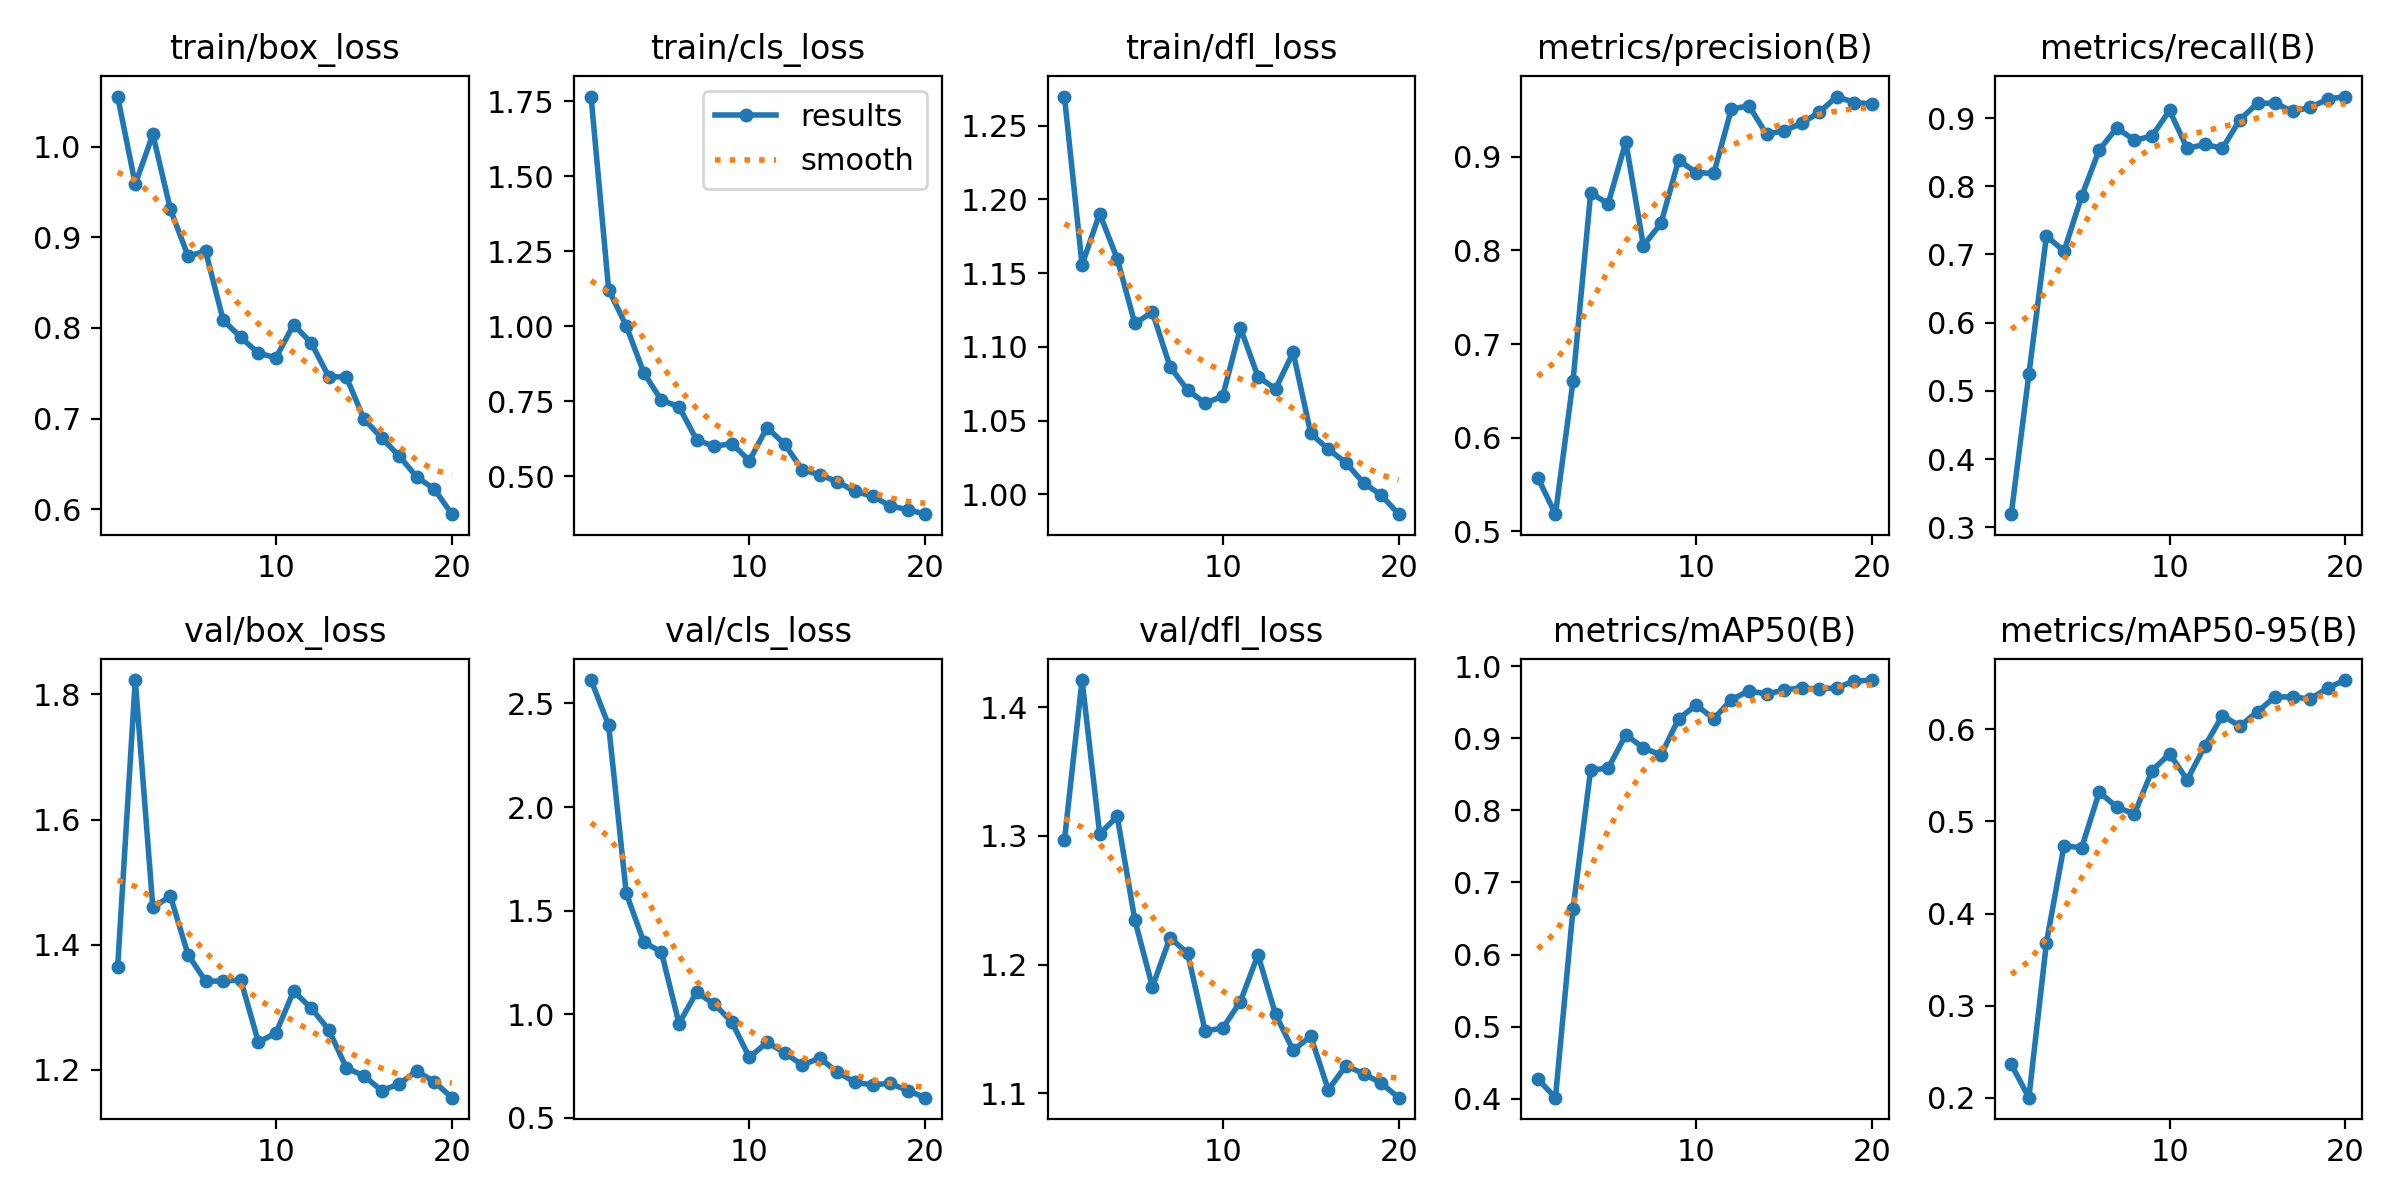

Mostrando: runs\detect\yolo_plate_detector13\results.png


In [ ]:
from IPython.display import Image, display
import os

runs_dir = os.path.join('runs', 'detect')
exp_prefix = 'yolo_plate_detector'

run_dirs = []
if os.path.exists(runs_dir):
    run_dirs = [d for d in os.listdir(runs_dir)
                if d.startswith(exp_prefix) and os.path.isdir(os.path.join(runs_dir, d))]

if not run_dirs:
    print(f'No se encontraron runs en {runs_dir} con prefijo "{exp_prefix}"')
else:

    def get_run_number(run_name):
        if run_name == exp_prefix:
            return 1
        try:
            return int(run_name.replace(exp_prefix, ''))
        except ValueError:
            return 0
    
    last_run = sorted(run_dirs, key=get_run_number)[-1]
    
    results_img = os.path.join(runs_dir, last_run, 'results.png')
    if os.path.exists(results_img):
        display(Image(filename=results_img))
        print(f'Mostrando: {results_img}')
    else:
        print(f'Results image not found en: {results_img}')
